# Promotional Event Detection

In [5]:
# Import required modules (matplotlib and seaborn need to be installed for first time)
import matplotlib.pyplot as plt # Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import pandas as pd # Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import scipy.stats as st # SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems
import datetime

%matplotlib inline
# When using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code

In [6]:
# Read the dataset file and load dataframe 'df'
dataset_file_path = r'Cripted_DB_Promo_detection.csv' # 'r' is for raw string
df = pd.read_csv(dataset_file_path, sep=';', decimal=',') # We use ';' as a separator because it's a semi-colon separated, should be ',' for comma separated
df.head() # Shows first rows of our df

,CUSTOMER,PRODOTTO,YW,START_DATE,END_DATE,PriceUnits,PriceVolume,Units,Volume,Value,WD
0,Customer A,BABY DRY DUO DWCT,2018-05,43129,43135,11.900000,56.000000,136,28.9,1618.4,9
1,Customer A,BABY DRY DUO DWCT,2018-06,43136,43142,9.086016,46.537869,8717,1701.9,79202.8,93
2,Customer A,BABY DRY DUO DWCT,2018-07,43143,43149,9.118637,46.978016,13264,2574.6,120949.6,99
3,Customer A,BABY DRY DUO DWCT,2018-08,43150,43156,9.191366,47.439744,10493,2033.0,96445.0,98
4,Customer A,BABY DRY DUO DWCT,2018-09,43157,43163,10.450014,53.784368,3523,684.5,36815.4,94


# Data Cleaning
- Drop null value rows

In [7]:
df.isnull().sum() # number of null rows in different columns (series)
df.shape # shape of our dataframe (row, column): (31242, 11)
df.dropna(how='any').shape # shape if we drop any null value row: (31239, 11)
df.dropna(how='any', inplace=True) # Using inplace will actually drop null values rows from our dataframe
# df.dropna(how='any', subset=['PriceVolume']) * We could do this either, because null values are in the PriceVolume Series

# Features & Variable Creation
- Start Date & End Date to their datetime64 format

- Generate High Sale Value (top 5% value) feature

- Generate Customer Category series from customer

In [8]:
# Start Date & End Date to their datetime64 format
df['START_DATE'] = df['YW'].apply(lambda yw: datetime.datetime.strptime('%s%s' %(yw,'-1'), '%Y-%W-%w')) # Week Start Date
df['END_DATE'] = df['YW'].apply(lambda yw: datetime.datetime.strptime('%s%s' %(yw, '-0'), '%Y-%W-%w')) # Week End Date

# Generate High Sale Value (top 5% value) feature
high_value_threshold = df['Value'].quantile(0.95) # (any-value-amount > threshold == top 5% sale value)
df['TOP VALUE'] = df['Value'].apply(lambda value: 1 if value >= high_value_threshold else 0)

# Convert Customer series to categorical datatype
df['CUSTOMER-CATEGORY']=df['CUSTOMER'].astype('category').cat.codes

# Show first rows of our df
df.head() 

,CUSTOMER,PRODOTTO,YW,START_DATE,END_DATE,PriceUnits,PriceVolume,Units,Volume,Value,WD,TOP VALUE,CUSTOMER-CATEGORY
0,Customer A,BABY DRY DUO DWCT,2018-05,2018-01-29,2018-02-04,11.900000,56.000000,136,28.9,1618.4,9,0,0
1,Customer A,BABY DRY DUO DWCT,2018-06,2018-02-05,2018-02-11,9.086016,46.537869,8717,1701.9,79202.8,93,1,0
2,Customer A,BABY DRY DUO DWCT,2018-07,2018-02-12,2018-02-18,9.118637,46.978016,13264,2574.6,120949.6,99,1,0
3,Customer A,BABY DRY DUO DWCT,2018-08,2018-02-19,2018-02-25,9.191366,47.439744,10493,2033.0,96445.0,98,1,0
4,Customer A,BABY DRY DUO DWCT,2018-09,2018-02-26,2018-03-04,10.450014,53.784368,3523,684.5,36815.4,94,1,0


 # 1- Correlation Analysis

In [9]:
df.corr() # correlation table of variables
# np.corrcoef(df['Units'], df['Volume'])
# st.pearsonr(df['Units'], df['PriceUnits'])
# sns.regplot(data=df, x='Units', y='PriceUnits')

,PriceUnits,PriceVolume,Units,Volume,Value,WD,TOP VALUE,CUSTOMER-CATEGORY
PriceUnits,1.000000,-0.187219,-0.144397,0.061244,0.048434,-0.359084,0.081880,0.107719
PriceVolume,-0.187219,1.000000,-0.121362,-0.167993,-0.130385,0.025043,-0.129316,0.014611
Units,-0.144397,-0.121362,1.000000,0.805331,0.833796,0.420362,0.599899,-0.241712
Volume,0.061244,-0.167993,0.805331,1.000000,0.980479,0.336700,0.719710,-0.170021
Value,0.048434,-0.130385,0.833796,0.980479,1.000000,0.386146,0.760929,-0.198910
WD,-0.359084,0.025043,0.420362,0.336700,0.386146,1.000000,0.276565,-0.092640
TOP VALUE,0.081880,-0.129316,0.599899,0.719710,0.760929,0.276565,1.000000,-0.171033
CUSTOMER-CATEGORY,0.107719,0.014611,-0.241712,-0.170021,-0.198910,-0.092640,-0.171033,1.000000


# Using Numpy

In [10]:
np.corrcoef(df['PriceUnits'], df['WD']) # -0.35908411
np.corrcoef(df['PriceUnits'], df['PriceVolume']) # -0.18721943
np.corrcoef(df['PriceUnits'], df['Units']) # -0.14439663
np.corrcoef(df['PriceVolume'], df['Volume']) # -0.1679931
np.corrcoef(df['PriceUnits'], df['Volume']) # 0.06124389
np.corrcoef(df['Units'], df['WD']) # 0.42036153 
np.corrcoef(df['Units'], df['Volume']) # 0.8053307
np.corrcoef(df['Units'], df['Value']) # 0.83379606
np.corrcoef(df['Value'], df['WD']) # 0.38614571
np.corrcoef(df['Value'], df['Volume']) # 0.98047871

array([[1.        , 0.98047871],
       [0.98047871, 1.        ]])

# Using Scipy

In [11]:
st.pearsonr(df['PriceUnits'], df['WD']) 
# -0.35908411273655283 negative correlation
st.pearsonr(df['PriceUnits'], df['PriceVolume']) 
# -0.18721943199351052 negative correlation
st.pearsonr(df['PriceUnits'], df['Units']) 
# -0.14439663490252186 negative correlation
st.pearsonr(df['PriceVolume'], df['Volume']) 
# -0.16799310096604553 negative correlation
st.pearsonr(df['PriceUnits'], df['Volume']) 
# 0.0612438890101534 positive correlation
st.pearsonr(df['Units'], df['WD']) 
# 0.42036153030323437 positive correlation
st.pearsonr(df['Units'], df['Volume']) 
# 0.8053307046287838 positive correlation
st.pearsonr(df['Units'], df['Value']) 
# 0.833796061095855 positive correlation
st.pearsonr(df['Value'], df['WD']) 
# 0.3861457083393341 positive correlation
st.pearsonr(df['Value'], df['Volume']) 
# 0.9804787118459396 positive correlation

(0.9804787118459396, 0.0)

# Data Visualization

<AxesSubplot:>

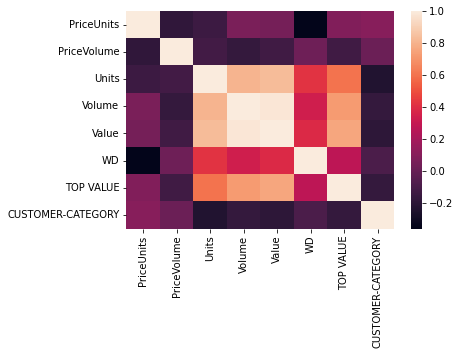

In [12]:
sns.heatmap(df.corr()) # correlation heatmap

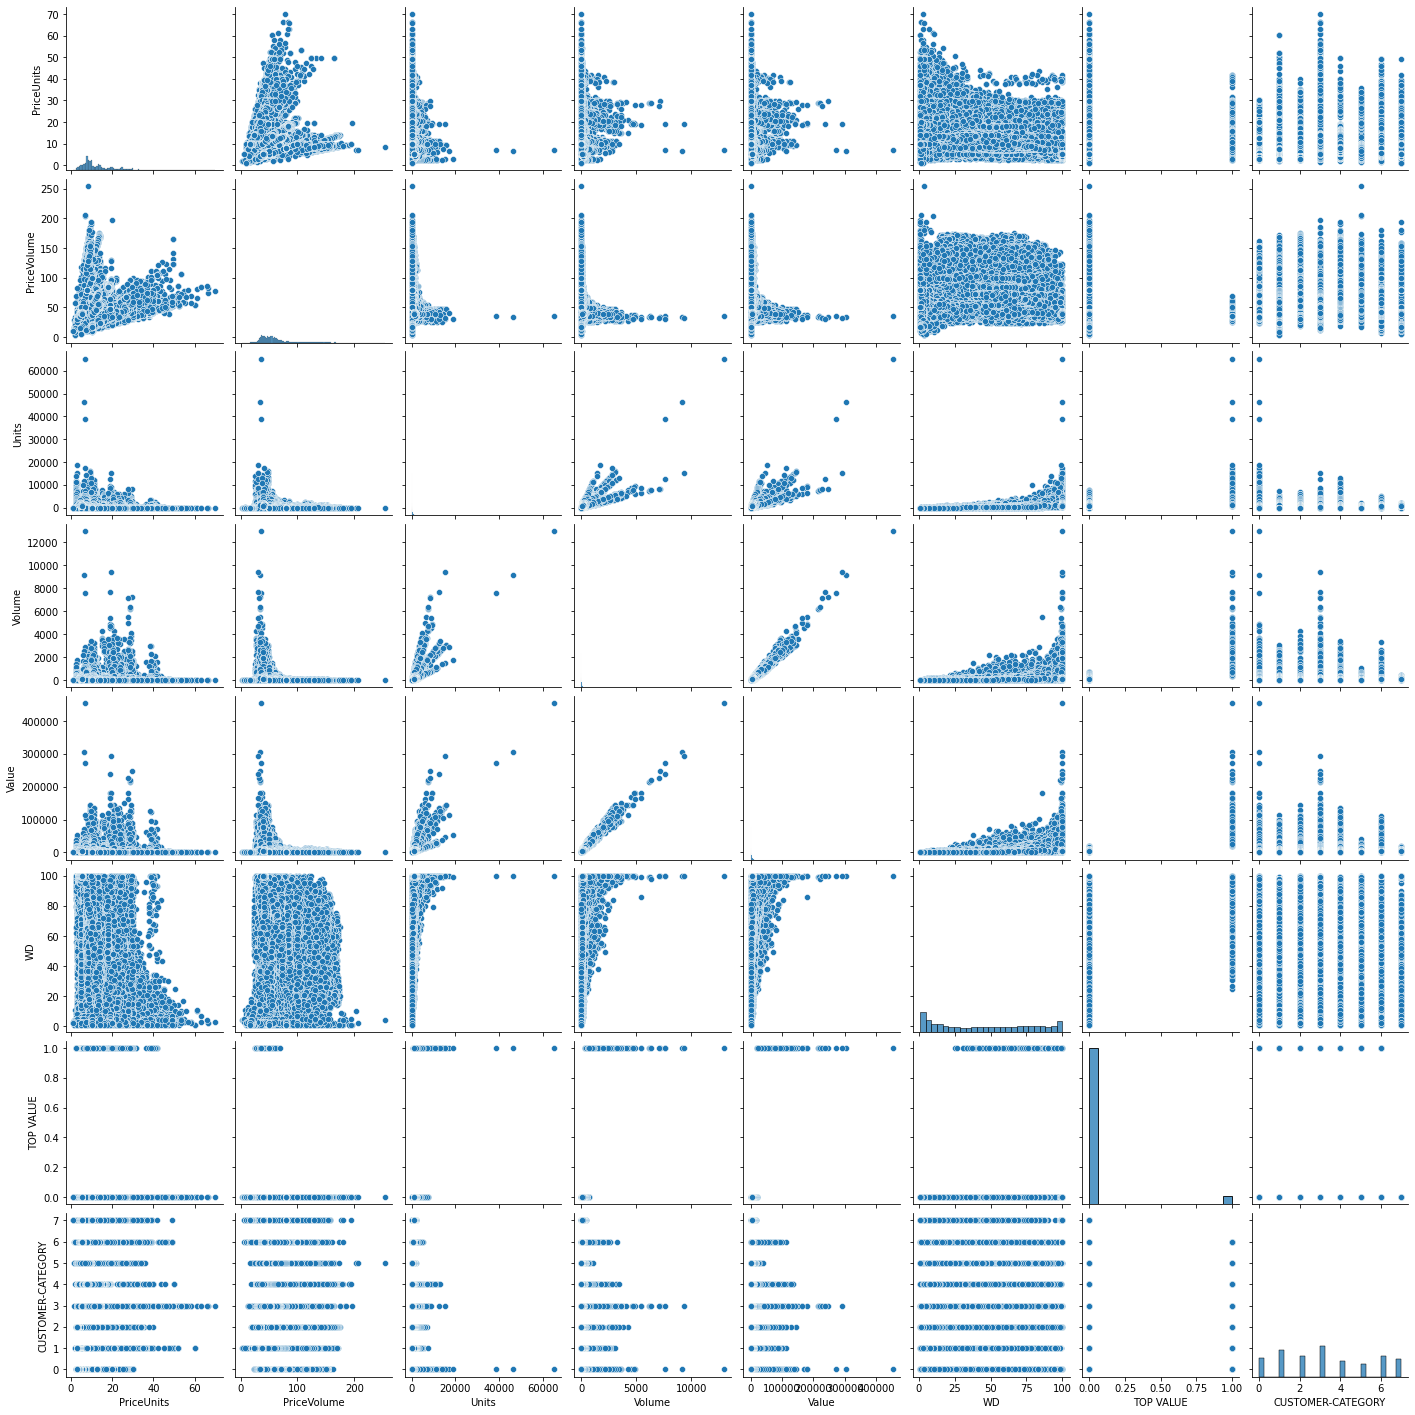

In [13]:
sns.pairplot(df) # representation, Pair Grid

# 2- Promotional Weeks Detection

<AxesSubplot:xlabel='YW'>

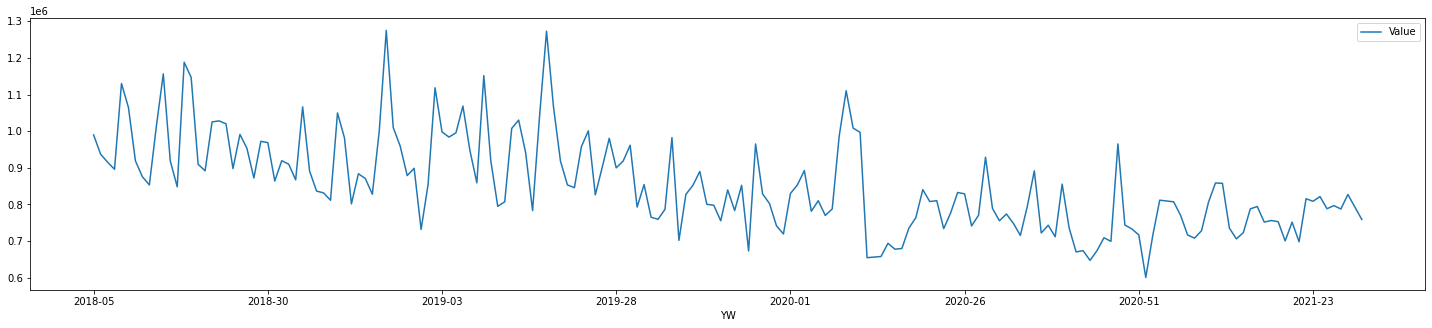

In [14]:
df.groupby('YW')[['Value']].sum().plot(figsize=(25,5)) # Group Weeks and thier Total Value

<AxesSubplot:xlabel='YW'>

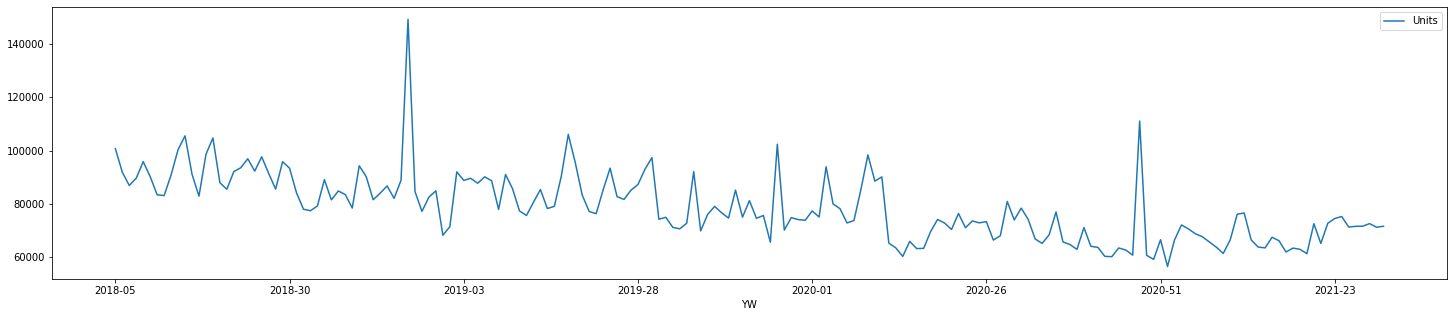

In [15]:
df.groupby('YW')[['Units']].sum().plot(figsize=(25,5)) # Group Weeks and thier Total Sold Units

# Most High Valued Weeks

In [16]:
value_df = df.groupby('YW')[['Value']].sum().sort_values(by='Value') # Get Top Total Sales Value grouped by week
value_df.head().sort_values(by='Value', ascending=False) # Descending Sort

,Value
YW,
2020-14,658079.9
2020-13,656486.3
2020-12,654849.5
2020-44,647439.8
2020-52,600945.0


# Most High Valued Customers

In [17]:
customer_df = df.groupby('CUSTOMER')[['Value']].sum().sort_values(by='Value') # Get Top Total Sales Value grouped by customers
customer_df.head().sort_values(by='Value', ascending=False) # Descending Sort

,Value
CUSTOMER,
Customer C,20792679.3
Customer E,17115477.7
Customer G,9204638.1
Customer H,5671667.5
Customer F,4660367.1


# Most High Valued Weeks

In [21]:
product_df = df.groupby('PRODOTTO')[['Value']].sum().sort_values(by='Value') # Get Top Total Sales Value grouped by customers
product_df.head().sort_values(by='Value', ascending=False) # Descending Sort

,Value
PRODOTTO,
COMPETITION 4,2013.2
COMPETITION 6,990.8
COMPETITION 20,293.4
COMPETITION 5,281.6
BABY DRY TRIO,129.4
